In [1]:
import matplotlib
matplotlib.rcParams['ps.useafm'] = True
matplotlib.rcParams['pdf.use14corefonts'] = True
matplotlib.rcParams['text.usetex'] = True
import re
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from format_param import prettify_param
from matplotlib import rc

In [2]:
prefix = "MAT_medium_ATTP_"
filename = "filtered_logs/ms_medium_attp_filtered_combined.txt"
s = open(filename, "r").readlines()    

In [3]:
raw_pr = []
raw_mem = []
raw_time = []
raw_final_mem = []
ln = 0
query_type = ""
flagFinal = False
for line in s:
    if line.startswith("START_OF_FINAL_STATS_REPORT"):
        flagFinal = True
    if line.startswith("Stats request at line"):
        ln = int(re.findall("\d+", line)[1])
        flagFinal = False
    if line.find(" timers") != -1:
        query_type = line.strip().split(" ")[0]
    if line.find(" ms = ") != -1 and flagFinal:
        t = line.strip().split(':')
        sketch = t[0].split('-')
        sketch = [sketch[0], ''.join(sketch[1:])]
        raw_time.append(sketch + [ln, query_type, int(t[1].split("=")[1].strip()[:-3])])
    if line.find("||ATA-BTB||_2 / ||A||_F^2") != -1:
        t = line.strip().split(':')
        sketch = t[0].split('-')
        sketch = [sketch[0], ''.join(sketch[1:])]
        pr_info = float(t[1].split('=')[-1])
        raw_pr.append(sketch + [pr_info])
    if line.find("MB") != -1:
        t = line.strip().split(':')
        sketch = t[0].split('-')
        t = [sketch[0], ''.join(sketch[1:]), ln, int(t[1].split("=")[0].strip()[:-2])]
        if flagFinal:
            raw_final_mem.append(t)
        else:
            raw_mem.append(t)

In [4]:
mem = pd.DataFrame(raw_mem, columns = ["Sketch", "Param", "Stream Size", "Memory Usage (B)"])
mem

,Sketch,Param,Stream Size,Memory Usage (B)
0,NORM_SAMPLING,ss400,500,4115456
1,NORM_SAMPLING,ss600,500,4216256
2,PFD,l10,500,392304
3,PFD,l20,500,800480
4,NORM_SAMPLING_WR,ss600,500,3757440
...,...,...,...,...
2495,PFD,l200,49000,13728448
2496,PFD,l150,49500,7004560
2497,PFD,l200,49500,13728448
2498,PFD,l150,50000,7004560


In [5]:
final_mem = pd.DataFrame(raw_final_mem, columns = ["Sketch", "Param", "Stream Size", "Memory Usage (B)"])
final_mem

,Sketch,Param,Stream Size,Memory Usage (B)
0,NORM_SAMPLING,ss400,50000,18955456
1,NORM_SAMPLING,ss600,50000,26086656
2,PFD,l10,50000,392304
3,PFD,l20,50000,800480
4,NORM_SAMPLING_WR,ss600,50000,23158064
5,NORM_SAMPLING_WR,ss700,50000,26162064
6,NORM_SAMPLING,ss150,50000,8147456
7,NORM_SAMPLING,ss200,50000,10464256
8,PFD,l40,50000,1624848
9,PFD,l60,50000,2489296


In [6]:
time = pd.DataFrame(raw_time, columns = ["Sketch", "Param", "Stream Size", "Type", "Time (ms)"])
time_processed = pd.merge(time, final_mem, on = ["Sketch", "Param", "Stream Size"]).drop(["Stream Size", "Param"], 1).drop_duplicates()
utime = time_processed[time_processed["Type"] == "Update"]
qtime = time_processed[time_processed["Type"] == "Query"]
qtime

<ipython-input-6-44ad82669181>:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  time_processed = pd.merge(time, final_mem, on = ["Sketch", "Param", "Stream Size"]).drop(["Stream Size", "Param"], 1).drop_duplicates()


,Sketch,Type,Time (ms),Memory Usage (B)
1,NORM_SAMPLING,Query,1943,18955456
3,NORM_SAMPLING,Query,2913,26086656
5,PFD,Query,77,392304
7,PFD,Query,155,800480
9,NORM_SAMPLING_WR,Query,3006,23158064
11,NORM_SAMPLING_WR,Query,3520,26162064
13,NORM_SAMPLING,Query,744,8147456
15,NORM_SAMPLING,Query,990,10464256
17,PFD,Query,335,1624848
19,PFD,Query,520,2489296


In [7]:
pr = pd.DataFrame(raw_pr, columns = ["Sketch", "Param", "Error"])
pr = pd.merge(pr, final_mem, on = ["Sketch", "Param"]).groupby(["Sketch", "Param", "Memory Usage (B)"]).mean().drop("Stream Size", 1)
pr = pd.DataFrame(pr.to_records())
pr

<ipython-input-7-5d4f77be9eee>:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  pr = pd.merge(pr, final_mem, on = ["Sketch", "Param"]).groupby(["Sketch", "Param", "Memory Usage (B)"]).mean().drop("Stream Size", 1)


,Sketch,Param,Memory Usage (B),Error
0,NORM_SAMPLING,ss10,769216,0.104930
1,NORM_SAMPLING,ss100,5742656,0.026017
2,NORM_SAMPLING,ss150,8147456,0.020328
3,NORM_SAMPLING,ss200,10464256,0.015431
4,NORM_SAMPLING,ss25,1791456,0.057322
5,NORM_SAMPLING,ss400,18955456,0.011273
6,NORM_SAMPLING,ss50,3193856,0.033156
7,NORM_SAMPLING,ss600,26086656,0.009718
8,NORM_SAMPLING_WR,ss10,671904,0.132538
9,NORM_SAMPLING_WR,ss100,5218640,0.024368


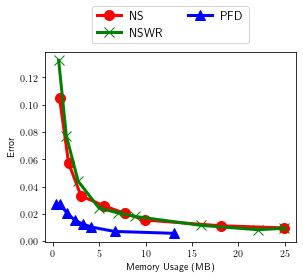

In [8]:
fig, ax = plt.subplots(figsize = (4.5, 3.5))
sketch_type = ["NORM_SAMPLING", "NORM_SAMPLING_WR", "PFD"]
abbrv = {
    "NORM_SAMPLING" : "NS",
    "NORM_SAMPLING_WR" : "NSWR",
    "PFD" : "PFD",    
}
        
linestyles = ["-", "--", "."]
colors = ["r", "g", "b"]
markers = ["o", "x", "^"]
ms = 10
lw = 3

cnt = 0
for sk in sketch_type:
    dat = pr[pr["Sketch"] == sk].sort_values(by = "Memory Usage (B)").transpose().to_numpy()
    plt.plot(dat[2] / 1048576.0, dat[3], color = colors[cnt], marker = markers[cnt], label = abbrv[sk], markersize = ms, linewidth = lw)
    cnt += 1
lgd = ax.legend(loc="upper center", bbox_to_anchor=(0.5, 1.27), ncol=2, fontsize=12)
ax.set_xlabel("Memory Usage (MB)")
ax.set_ylabel("Error")
#plt.tight_layout()
plt.savefig(prefix + 'err.pdf', bbox_extra_artists=[lgd], bbox_inches='tight')

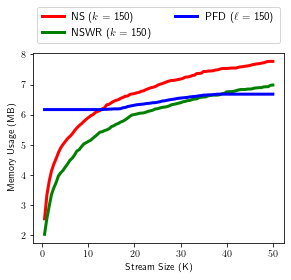

In [9]:
fig, ax = plt.subplots(figsize = (4.5, 3.5))
cnt = 0

sketch_param = {
    "NORM_SAMPLING" : ["ss150"],
    "NORM_SAMPLING_WR" : ["ss150"],
    "PFD" : ["l150"],
}

for sk in sketch_type:
    cnt0 = 0
    for p in sketch_param[sk]:
        dat = mem[(mem["Sketch"] == sk) & (mem["Param"] == p)].sort_values(by = "Stream Size").transpose().to_numpy()
        plt.plot(dat[2] / 1000.0, dat[3] / 1048576.0, label = "%s %s" % (abbrv[sk], prettify_param(p)), markersize = ms, color = colors[cnt], linestyle = linestyles[cnt0], linewidth = lw)
        cnt0 += 1
    cnt += 1

lgd = ax.legend(loc="upper center", bbox_to_anchor=(0.5, 1.27), ncol=2, fontsize=11)
ax.set_xlabel("Stream Size (K)")
ax.set_ylabel("Memory Usage (MB)")
#plt.tight_layout()
plt.savefig(prefix + 'mem.pdf', bbox_extra_artists=[lgd], bbox_inches='tight')

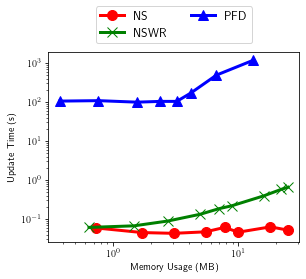

In [10]:
fig, ax = plt.subplots(figsize = (4.5, 3.5))
cnt = 0
for sk in sketch_type:
    dat = utime[utime["Sketch"] == sk].sort_values(by = "Memory Usage (B)").transpose().to_numpy()
    plt.plot(dat[-1] / 1048576.0, dat[-2]/1000.0, color = colors[cnt], marker = markers[cnt], label = abbrv[sk], markersize = ms, linewidth = lw)
    cnt += 1

lgd = ax.legend(loc="upper center", bbox_to_anchor=(0.5, 1.27), ncol=2, fontsize=12)
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel("Memory Usage (MB)")
ax.set_ylabel("Update Time (s)")
#plt.tight_layout()
plt.savefig(prefix + 'utime.pdf', bbox_extra_artists=[lgd], bbox_inches='tight')

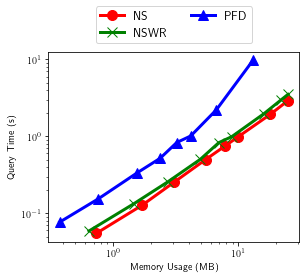

In [11]:
fig, ax = plt.subplots(figsize = (4.5, 3.5))
cnt = 0
for sk in sketch_type:
    dat = qtime[qtime["Sketch"] == sk].sort_values(by = "Memory Usage (B)").transpose().to_numpy()
    plt.plot(dat[-1] / 1048576.0, dat[-2]/1000.0, color = colors[cnt], marker = markers[cnt], label = abbrv[sk], markersize = ms, linewidth = lw)
    cnt += 1

lgd = ax.legend(loc="upper center", bbox_to_anchor=(0.5, 1.27), ncol=2, fontsize=12)
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel("Memory Usage (MB)")
ax.set_ylabel("Query Time (s)")
#plt.tight_layout()
plt.savefig(prefix + 'qtime.pdf', bbox_extra_artists=[lgd], bbox_inches='tight')